# SPLEX Project — Heart Disease (UCI) Prediction & Data Exploration
### Students :
| Last name | First name | Student number |
|----------|-------------------|---------|
| ALOUAY | Nour Eddine | 21424027 |
| Saidi  | Oumayma | 21219315 |
## Project objective
Build and compare machine learning models to predict the presence of heart disease from clinical measurements, with an emphasis on:
- rigorous preprocessing and validation
- baseline models + hyperparameter tuning
- feature selection and interpretability
## Dataset description
The dataset contains clinical features such as age, sex, chest pain type, resting blood pressure, cholesterol, ECG results, etc.
The target variable is target (binary classification):
- target = 1: presence of heart disease
- target = 0 : absence of heart disease

## Related work (Week 1)

We briefly reviewed prior work on heart disease prediction from clinical/tabular data and on interpretable risk scores.

**(1) UCI Heart Disease dataset description (Cleveland subset)**
- The repository describes the classical experimental setting: predicting disease presence from a subset of 14 variables.

**(2) Interpretable clinical scores / explainable models**
- In healthcare, interpretability is often required for adoption: linear models and additive scores are widely used because they provide transparent decision rules.

**(3) Typical ML approaches for clinical tabular data**
- Standard baselines such as logistic regression, SVM, kNN and tree-based models often perform strongly, while careful validation and leakage control (duplicates) are critical.

**Conclusion:** We therefore combine strong baselines + tuning + feature selection, and propose an interpretable scorecard as a final approach.

In [ ]:
!pip -q install kagglehub

In [ ]:
import kagglehub

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectFdr, f_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score







from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, classification_report
)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Problem & dataset

We study the **UCI Heart Disease dataset** to predict the presence of heart disease from clinical measurements.

**Task:** Binary classification  
**Target:** `target` (0/1)

**Week 1 objectives**
- Download and load the dataset
- Clean data (duplicates), perform EDA
- Train standard baseline models with cross-validation
- Evaluate on a held-out test set

**Week 2 objectives**
- Hyperparameter tuning (GridSearchCV)
- Feature selection (filter + embedded)
- Compare performance vs model complexity (number of selected features)
# Week 1 — Download, cleaning, EDA, baseline models

## 2. Download dataset (KaggleHub)
We download the dataset programmatically using `kagglehub`.

In [ ]:
path = kagglehub.dataset_download("thisishusseinali/uci-heart-disease-data")
print("Path to dataset files:", path)

files = glob.glob(os.path.join(path, "**/*"), recursive=True)
files = [f for f in files if os.path.isfile(f)]
csv_files = [f for f in files if f.lower().endswith(".csv")]

print("CSV files found:")
for f in csv_files:
    print(" -", f)

Using Colab cache for faster access to the 'uci-heart-disease-data' dataset.
Path to dataset files: /kaggle/input/uci-heart-disease-data
CSV files found:
 - /kaggle/input/uci-heart-disease-data/heart_disease_data.csv


## 3. Load data
We load the main CSV file and inspect the schema.

In [ ]:
if len(csv_files) == 1:
    data_path = csv_files[0]
else:
    preferred = [f for f in csv_files if "heart" in os.path.basename(f).lower()]
    data_path = preferred[0] if preferred else csv_files[0]

print("Using:", data_path)
df = pd.read_csv(data_path)

display(df.head())
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

Using: /kaggle/input/uci-heart-disease-data/heart_disease_data.csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,0,130,256,1,0,150,1,0.0,2,2,3,0
1,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
2,44,0,2,118,242,0,1,149,0,0.3,1,1,2,1
3,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
4,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1



Shape: (606, 14)

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Dtypes:
 age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## 4. Dataset overview (target, missing values, duplicates)

We check:
- target distribution
- missing values
- duplicates (important to avoid data leakage)

In [ ]:
print("Shape:", df.shape)

print("\nTarget distribution (counts):")
display(df["target"].value_counts())

print("\nTarget distribution (percentage):")
display((df["target"].value_counts(normalize=True)*100).round(2))

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
print("\nMissing values (only >0):")
display(missing_table[missing_table["missing_count"] > 0])

print("\nNumber of duplicated rows:", df.duplicated().sum())

Shape: (606, 14)

Target distribution (counts):


,count
target,
1,330
0,276



Target distribution (percentage):


,proportion
target,
1,54.46
0,45.54



Missing values (only >0):


,missing_count,missing_pct



Number of duplicated rows: 304


## 5. Data cleaning: remove duplicates

A large number of duplicated rows can inflate performance (train/test leakage).
We remove duplicates and continue with the cleaned dataset.

In [ ]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)

print("After dropping duplicates:")
print("Shape:", df.shape)

print("\nTarget distribution (counts):")
display(df["target"].value_counts())

print("\nTarget distribution (percentage):")
display((df["target"].value_counts(normalize=True)*100).round(2))

After dropping duplicates:
Shape: (302, 14)

Target distribution (counts):


,count
target,
1,164
0,138



Target distribution (percentage):


,proportion
target,
1,54.3
0,45.7


2 barplots “Avant nettoyage” vs “Après suppression des doublons”

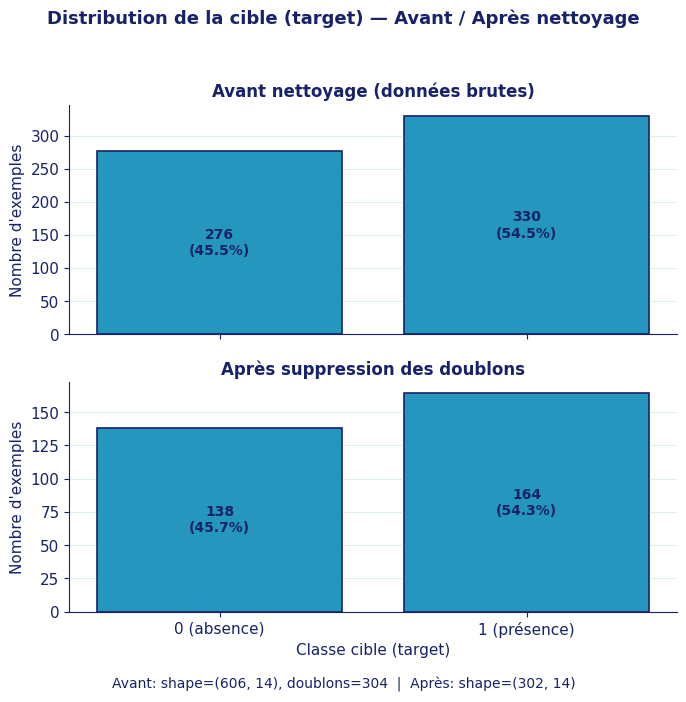

In [ ]:
# Couleur bleu Sorbonne pour la présentation
# --- Couleurs (bleu Sorbonne + déclinaisons) ---
SU_BLUE = "#172269"
SU_BLUE_LIGHT = "#2596be"
SU_BLUE_PALE = "#2596be"

TEXT_BLUE = SU_BLUE
EDGE_BLUE = SU_BLUE
plt.rcParams.update({
    # Couleurs globales
    "text.color": SU_BLUE,
    "axes.labelcolor": SU_BLUE,
    "axes.edgecolor": SU_BLUE,
    "xtick.color": SU_BLUE,
    "ytick.color": SU_BLUE,
    "axes.titlecolor": SU_BLUE,

    # Taille police
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,

    # Styles des axes et grille
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": SU_BLUE_LIGHT,
    "grid.alpha": 0.15,

    # Style défaut des courbes
    "lines.color": SU_BLUE,
    "patch.edgecolor": SU_BLUE,

    # Style légende
    "legend.edgecolor": SU_BLUE,
    "legend.fontsize": 10,
})
def sorbonne_df_style(df):
    return df.style.set_properties(**{
        'color': SU_BLUE,
        'border-color': SU_BLUE,
    }).set_table_styles([
        {'selector': 'th', 'props': [('color', SU_BLUE), ('border', f'1px solid {SU_BLUE}')]}
    ])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Patch global : transforme automatiquement TOUT DataFrame affiché avec display()
pd.io.formats.style.Styler.render = lambda self, **kwargs: sorbonne_df_style(self.data)._repr_html_()
# --- Charger dataset brut + stats ---
df_raw = pd.read_csv(data_path)
raw_shape = df_raw.shape
raw_dup = df_raw.duplicated().sum()
raw_counts = df_raw["target"].value_counts().sort_index()
raw_pct = (df_raw["target"].value_counts(normalize=True).sort_index() * 100)

# --- Stats après nettoyage (df est déjà nettoyé chez toi) ---
clean_shape = df.shape
clean_counts = df["target"].value_counts().sort_index()
clean_pct = (df["target"].value_counts(normalize=True).sort_index() * 100)

# --- Figure (2 lignes, 1 colonne) ---
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

def barplot_with_center_text(ax, counts, pct, title, bar_color):
    x = np.arange(len(counts))
    bars = ax.bar(x, counts.values, color=bar_color, edgecolor=EDGE_BLUE, linewidth=1.2)

    ax.set_title(title, color=TEXT_BLUE, fontsize=12, fontweight="bold")
    ax.set_ylabel("Nombre d'exemples", color=TEXT_BLUE)
    ax.tick_params(axis="y", colors=TEXT_BLUE)
    ax.tick_params(axis="x", colors=TEXT_BLUE)

    # Texte centré DANS chaque barre
    for i, b in enumerate(bars):
        h = b.get_height()
        label = f"{counts.iloc[i]}\n({pct.iloc[i]:.1f}%)"
        ax.text(
            b.get_x() + b.get_width()/2,
            h/2,                     # centre vertical
            label,
            ha="center", va="center",
            color=TEXT_BLUE,
            fontsize=10,
            fontweight="bold"
        )

    # Style léger
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(EDGE_BLUE)
    ax.spines["bottom"].set_color(EDGE_BLUE)
    ax.grid(axis="y", alpha=0.15)

# Plot 1: Avant
barplot_with_center_text(
    axes[0], raw_counts, raw_pct,
    title="Avant nettoyage (données brutes)",
    bar_color=SU_BLUE_PALE
)

# Plot 2: Après
barplot_with_center_text(
    axes[1], clean_counts, clean_pct,
    title="Après suppression des doublons",
    bar_color=SU_BLUE_LIGHT
)

axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["0 (absence)", "1 (présence)"], color=TEXT_BLUE)
axes[1].set_xlabel("Classe cible (target)", color=TEXT_BLUE)

# Titre global + résumé
fig.suptitle(
    "Distribution de la cible (target) — Avant / Après nettoyage",
    color=TEXT_BLUE, fontsize=13, fontweight="bold", y=0.98
)

fig.text(
    0.5, 0.01,
    f"Avant: shape={raw_shape}, doublons={raw_dup}  |  Après: shape={clean_shape}",
    ha="center", color=TEXT_BLUE, fontsize=10
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Feature types (categorical vs numeric)

Some columns are categorical codes (even if stored as integers).  
We define explicit groups for preprocessing.
## Variable dictionary (coding)

Many columns are categorical codes. We document the observed categories and (when possible) their medical meaning.
This improves interpretability of coefficients and scorecard rules.

In [ ]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numeric_features = [c for c in df.columns if c not in categorical_features + ["target"]]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

uniques = pd.DataFrame({
    "feature": df.columns,
    "n_unique": [df[c].nunique() for c in df.columns]
}).sort_values("n_unique")
display(uniques)

Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numeric features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


,feature,n_unique
1,sex,2
5,fbs,2
13,target,2
8,exang,2
6,restecg,3
10,slope,3
12,thal,4
2,cp,4
11,ca,5
9,oldpeak,40


In [ ]:
# Show unique values for coded categorical columns (from THIS dataset)
coding_summary = []
for c in categorical_features:
    coding_summary.append({
        "feature": c,
        "unique_values": sorted(df[c].unique().tolist()),
        "n_unique": df[c].nunique()
    })

coding_df = pd.DataFrame(coding_summary)
display(coding_df)

,feature,unique_values,n_unique
0,sex,"[0, 1]",2
1,cp,"[0, 1, 2, 3]",4
2,fbs,"[0, 1]",2
3,restecg,"[0, 1, 2]",3
4,exang,"[0, 1]",2
5,slope,"[0, 1, 2]",3
6,ca,"[0, 1, 2, 3, 4]",5
7,thal,"[0, 1, 2, 3]",4


## 7. EDA

We focus on:
- descriptive statistics for numeric variables
- correlation matrix for numeric variables
- boxplots of numeric variables by target

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2
target,302.0,0.543046,0.498970,0.0,0.00,1.0,1.00,1.0


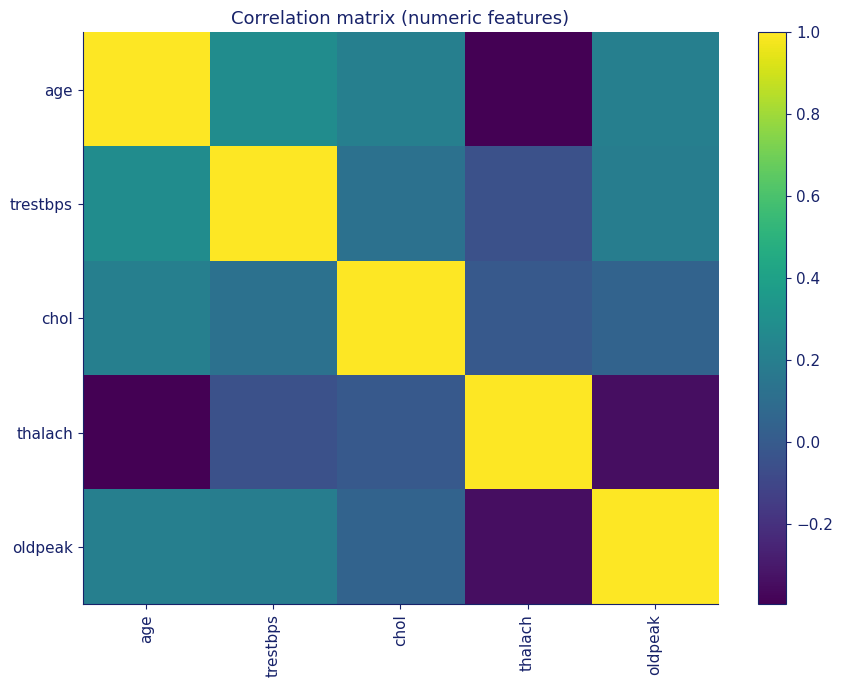

<Figure size 640x480 with 0 Axes>

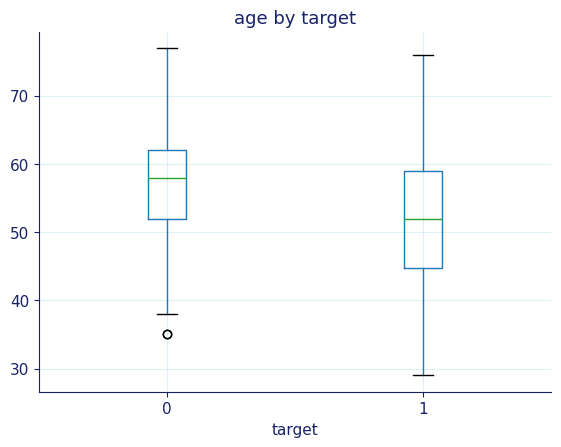

<Figure size 640x480 with 0 Axes>

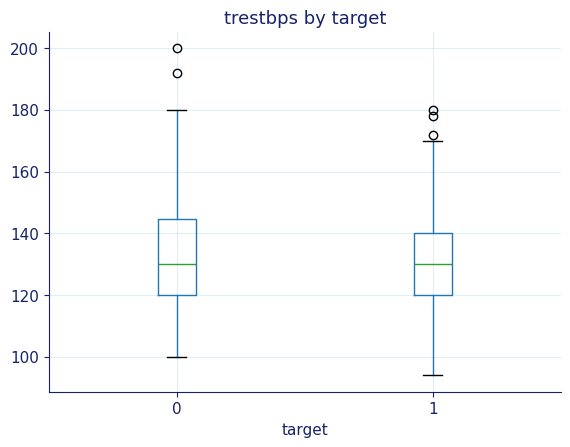

<Figure size 640x480 with 0 Axes>

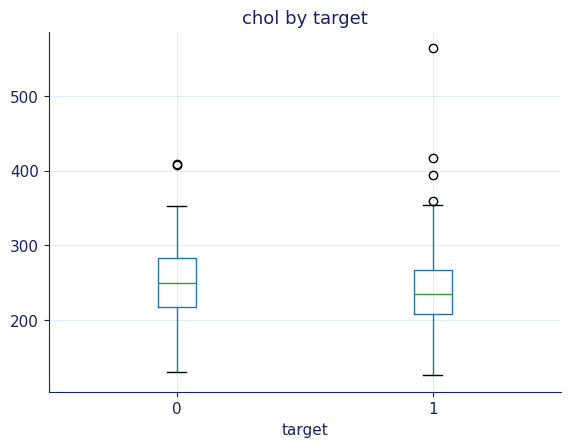

<Figure size 640x480 with 0 Axes>

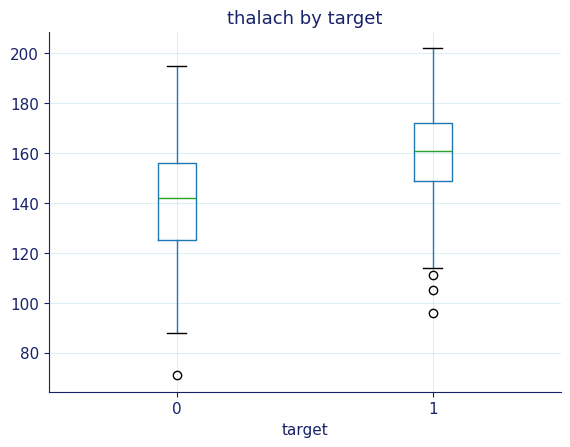

<Figure size 640x480 with 0 Axes>

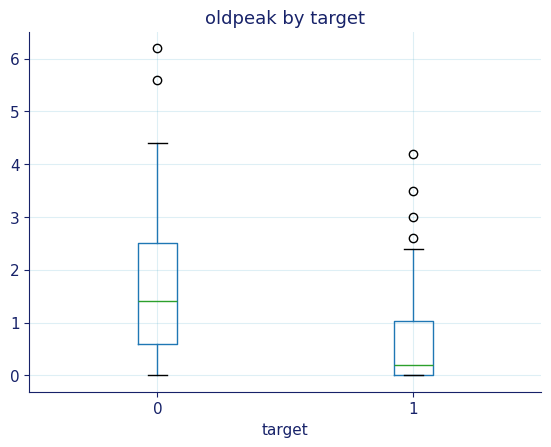

In [ ]:
display(df[numeric_features + ["target"]].describe().T)

# Correlation matrix (numeric)
corr = df[numeric_features].corr()
plt.figure(figsize=(9, 7))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(numeric_features)), numeric_features, rotation=90)
plt.yticks(range(len(numeric_features)), numeric_features)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

# Boxplots by target (numeric only)
for c in numeric_features:
    plt.figure()
    df.boxplot(column=c, by="target")
    plt.title(f"{c} by target")
    plt.suptitle("")
    plt.show()

## 8. Preprocessing & train/test split

Pipeline:
- numeric: median imputation + scaling
- categorical: mode imputation + one-hot encoding

We use a stratified 80/20 split.

In [ ]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (241, 13) Test shape: (61, 13)


## 9. Baseline models (Week 1)

We evaluate standard classifiers with 5-fold stratified CV:
- Logistic Regression
- SVM (RBF)
- kNN
- Gaussian Naive Bayes
- Random Forest

Metrics: Accuracy, F1, ROC-AUC

In [ ]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "SVM_RBF": SVC(kernel="rbf", probability=True),
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"acc": "accuracy", "f1": "f1", "auc": "roc_auc"}

rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "model": name,
        "cv_acc_mean": np.mean(scores["test_acc"]),
        "cv_f1_mean": np.mean(scores["test_f1"]),
        "cv_auc_mean": np.mean(scores["test_auc"])
    })

results_df = pd.DataFrame(rows).sort_values("cv_auc_mean", ascending=False)
display(results_df)

,model,cv_acc_mean,cv_f1_mean,cv_auc_mean
0,LogReg,0.846599,0.859312,0.923219
4,RandomForest,0.858844,0.872587,0.920934
1,SVM_RBF,0.846599,0.859334,0.920487
2,kNN,0.846429,0.862570,0.915372
3,GaussianNB,0.771939,0.793072,0.866757


## 10. Best baseline evaluation on test (Logistic Regression)

Logistic regression achieves the best baseline CV AUC and is interpretable.
We fit it on train and evaluate on the held-out test set.

Test Accuracy: 0.885
Test F1:       0.892
Test ROC-AUC:  0.931

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.91      0.88      0.89        33

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



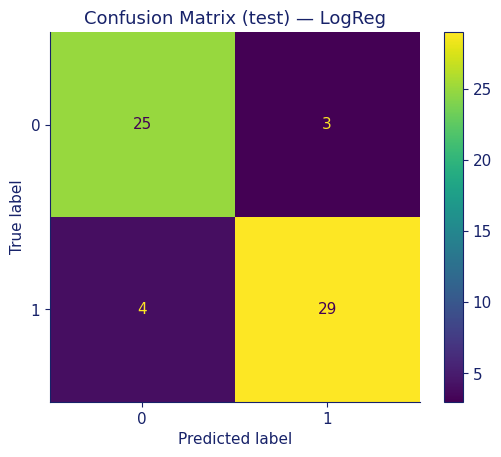

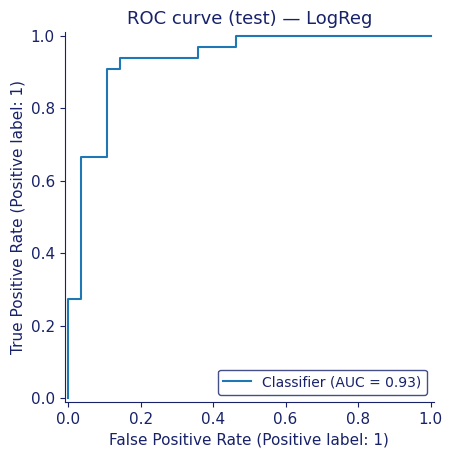

In [ ]:
best_pipe = Pipeline(steps=[("preprocess", preprocess),
                           ("model", LogisticRegression(max_iter=2000))])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {acc:.3f}")
print(f"Test F1:       {f1:.3f}")
print(f"Test ROC-AUC:  {auc:.3f}\n")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix (test) — LogReg")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC curve (test) — LogReg")
plt.show()

## 11. Interpretability (LogReg coefficients)

We extract the largest absolute coefficients after preprocessing (one-hot for categorical).
This gives the strongest drivers of the prediction.

In [ ]:
logreg_pipe = Pipeline(steps=[("preprocess", preprocess),
                             ("model", LogisticRegression(max_iter=2000))])
logreg_pipe.fit(X_train, y_train)

# Feature names after one-hot
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + cat_feature_names

coef = logreg_pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()

display(coef_df.sort_values("abs_coef", ascending=False).head(20))

,feature,coef,abs_coef
21,ca_0,1.225001,1.225001
7,cp_0,-1.145846,1.145846
23,ca_2,-0.939546,0.939546
5,sex_0,0.763241,0.763241
19,slope_1,-0.759170,0.759170
6,sex_1,-0.725387,0.725387
10,cp_3,0.718323,0.718323
29,thal_3,-0.717610,0.717610
20,slope_2,0.650134,0.650134
9,cp_2,0.639354,0.639354


## Week 1 summary

- Raw dataset: 606 rows → **302 unique samples after removing 304 duplicates**
- No missing values
- Target distribution (clean): ~54% positives / 46% negatives
- Baseline performance: Logistic Regression reaches ~0.92 CV AUC and ~0.93 test AUC

# Week 2 — Hyperparameter tuning and feature selection

We:
1. Tune main baselines with GridSearchCV (ROC-AUC).
2. Perform feature selection (Filter + Embedded).
3. Compare performance vs model sparsity.

In [ ]:
pipe_logreg = Pipeline(steps=[("preprocess", preprocess),
                             ("model", LogisticRegression(max_iter=5000))])

pipe_svm = Pipeline(steps=[("preprocess", preprocess),
                          ("model", SVC(kernel="rbf", probability=True))])

pipe_knn = Pipeline(steps=[("preprocess", preprocess),
                          ("model", KNeighborsClassifier())])

pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                         ("model", RandomForestClassifier(random_state=RANDOM_STATE))])

param_logreg = {"model__C": [0.01, 0.1, 1, 10, 100]}
param_svm = {"model__C": [0.1, 1, 10, 100], "model__gamma": ["scale", 0.01, 0.1, 1]}
param_knn = {"model__n_neighbors": [3,5,7,9,11,15], "model__weights": ["uniform","distance"], "model__p":[1,2]}
param_rf = {"model__n_estimators":[200,500,800], "model__max_depth":[None,3,5,8,12],
            "model__min_samples_split":[2,5,10], "model__min_samples_leaf":[1,2,4]}

searches = {
    "LogReg": (pipe_logreg, param_logreg),
    "SVM_RBF": (pipe_svm, param_svm),
    "kNN": (pipe_knn, param_knn),
    "RandomForest": (pipe_rf, param_rf)
}

best_estimators = {}
rows = []
for name, (pipe, params) in searches.items():
    gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    rows.append({"model": name, "best_cv_auc": gs.best_score_, "best_params": gs.best_params_})

gs_results_df = pd.DataFrame(rows).sort_values("best_cv_auc", ascending=False)
display(gs_results_df)

,model,best_cv_auc,best_params
2,kNN,0.927448,"{'model__n_neighbors': 11, 'model__p': 1, 'mod..."
3,RandomForest,0.927312,"{'model__max_depth': 8, 'model__min_samples_le..."
0,LogReg,0.923219,{'model__C': 1}
1,SVM_RBF,0.922572,"{'model__C': 10, 'model__gamma': 0.01}"


## 12. Tuned models evaluation on test

We evaluate tuned kNN, tuned RandomForest, and tuned Logistic Regression on the test set.

In [ ]:
def eval_on_test(name, estimator):
    y_pred = estimator.predict(X_test)
    if hasattr(estimator.named_steps["model"], "predict_proba"):
        y_proba = estimator.predict_proba(X_test)[:, 1]
    else:
        y_scores = estimator.decision_function(X_test)
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

    return {
        "model": name,
        "test_acc": accuracy_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred),
        "test_auc": roc_auc_score(y_test, y_proba)
    }

best_knn = best_estimators["kNN"]
best_rf = best_estimators["RandomForest"]
best_logreg = best_estimators["LogReg"]

test_results_df = pd.DataFrame([
    eval_on_test("kNN_tuned", best_knn),
    eval_on_test("RF_tuned", best_rf),
    eval_on_test("LogReg_tuned", best_logreg),
]).sort_values("test_auc", ascending=False)

display(test_results_df)

,model,test_acc,test_f1,test_auc
2,LogReg_tuned,0.885246,0.892308,0.930736
0,kNN_tuned,0.868852,0.882353,0.929654
1,RF_tuned,0.852459,0.861538,0.910173


## 13. Best tuned model (visual diagnostics)

We display the confusion matrix and ROC curve for the best tuned model on the test set.

Best tuned model on test: LogReg_tuned


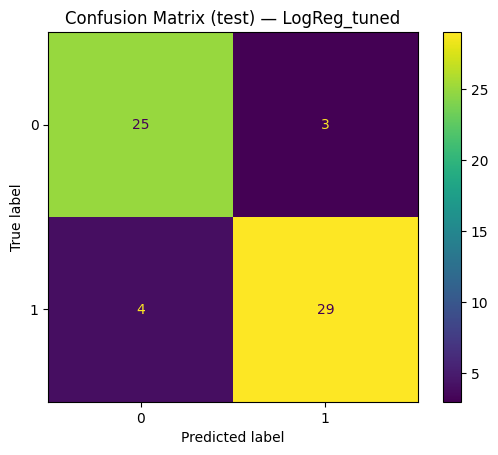

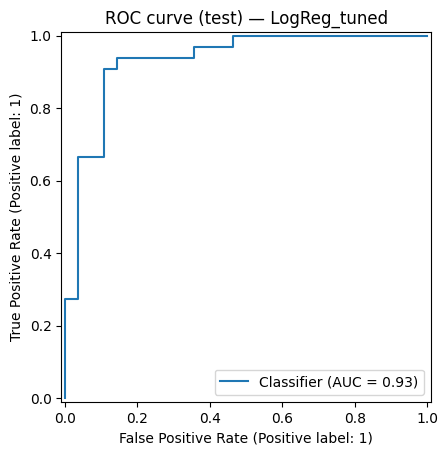

In [ ]:
best_test_model_name = test_results_df.iloc[0]["model"]
print("Best tuned model on test:", best_test_model_name)

best_map = {"kNN_tuned": best_knn, "RF_tuned": best_rf, "LogReg_tuned": best_logreg}
best_est = best_map[best_test_model_name]

y_pred = best_est.predict(X_test)
if hasattr(best_est.named_steps["model"], "predict_proba"):
    y_proba = best_est.predict_proba(X_test)[:, 1]
else:
    y_scores = best_est.decision_function(X_test)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f"Confusion Matrix (test) — {best_test_model_name}")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC curve (test) — {best_test_model_name}")
plt.show()

## 14. Feature selection (filter + embedded)

We compare compact models:

- Filter: SelectFdr (ANOVA F-test) + LogReg
- Embedded: L1 Logistic Regression
- Embedded: Elastic Net-like (SGDClassifier)

We report both CV AUC and the number of selected features.

In [ ]:
# Filter selection (FDR)
pipe_fdr_logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectFdr(score_func=f_classif, alpha=0.05)),
    ("model", LogisticRegression(max_iter=5000))
])

scores = cross_validate(pipe_fdr_logreg, X_train, y_train, cv=cv,
                        scoring={"auc":"roc_auc","f1":"f1","acc":"accuracy"}, n_jobs=-1)

print("FDR(LogReg) CV AUC:", np.mean(scores["test_auc"]), "+/-", np.std(scores["test_auc"]))
print("FDR(LogReg) CV F1 :", np.mean(scores["test_f1"]), "+/-", np.std(scores["test_f1"]))
print("FDR(LogReg) CV Acc:", np.mean(scores["test_acc"]), "+/-", np.std(scores["test_acc"]))

pipe_fdr_logreg.fit(X_train, y_train)
selector = pipe_fdr_logreg.named_steps["select"]
print("Selected features (after one-hot):", selector.get_support().sum())


# Embedded selection (L1 Logistic Regression)
pipe_l1 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000, penalty="l1", solver="liblinear"))
])

gs_l1 = GridSearchCV(pipe_l1, {"model__C":[0.01,0.1,1,10,100]}, scoring="roc_auc", cv=cv, n_jobs=-1)
gs_l1.fit(X_train, y_train)

best_l1 = gs_l1.best_estimator_
print("Best L1 LogReg AUC:", gs_l1.best_score_)
print("Best params:", gs_l1.best_params_)

coef = best_l1.named_steps["model"].coef_.ravel()
print("Non-zero coefficients:", np.sum(np.abs(coef) > 1e-9))

# Embedded selection (ElasticNet-like SGD)

pipe_en = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SGDClassifier(loss="log_loss", penalty="elasticnet",
                            max_iter=2000, tol=1e-3, random_state=RANDOM_STATE))
])

param_en = {"model__alpha":[1e-4, 1e-3, 1e-2], "model__l1_ratio":[0.1, 0.5, 0.9]}
gs_en = GridSearchCV(pipe_en, param_en, scoring="roc_auc", cv=cv, n_jobs=-1)
gs_en.fit(X_train, y_train)

best_en = gs_en.best_estimator_
print("Best ElasticNet-like AUC:", gs_en.best_score_)
print("Best params:", gs_en.best_params_)

coef = best_en.named_steps["model"].coef_.ravel()
print("Non-zero coefficients:", np.sum(np.abs(coef) > 1e-9))

FDR(LogReg) CV AUC: 0.9186350686350686 +/- 0.03806805155102697
FDR(LogReg) CV F1 : 0.8844888837820667 +/- 0.02209629236006477
FDR(LogReg) CV Acc: 0.8712585034013605 +/- 0.02474387519217884
Selected features (after one-hot): 21
Best L1 LogReg AUC: 0.9197228697228697
Best params: {'model__C': 10}
Non-zero coefficients: 23
Best ElasticNet-like AUC: 0.9215358715358715
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.1}
Non-zero coefficients: 26


## Unsupervised exploration (Week 2)

As an exploratory step, we perform PCA on the preprocessed data and apply KMeans clustering.
We then compare cluster assignments with the true target labels (post-hoc).

## Bayesian Networks (Week 2)

We evaluate whether a **Bayesian Network (BN)** is suitable for explaining/predicting the target. :contentReference[oaicite:2]{index=2}

Because Bayesian Networks in pgmpy require **discrete variables**, we:
- discretize continuous variables into quantile bins,
- keep categorical codes as they are,
- learn the BN structure from data (Hill-Climb + BIC),
- fit parameters (maximum likelihood),
- evaluate predictive performance using ROC-AUC.

Explained variance (2 PCs): 0.381
ARI (clusters vs target): 0.28535663690122315
Silhouette score: 0.408


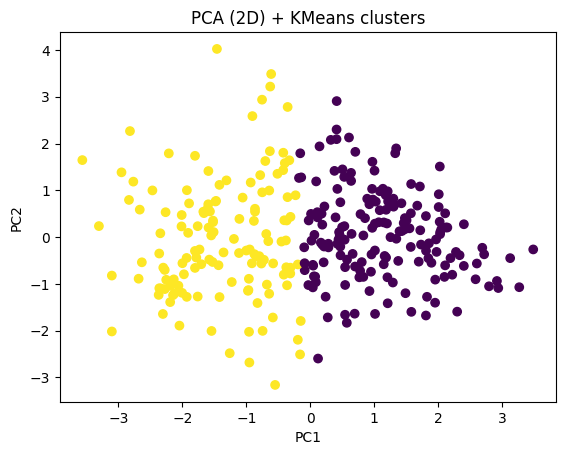

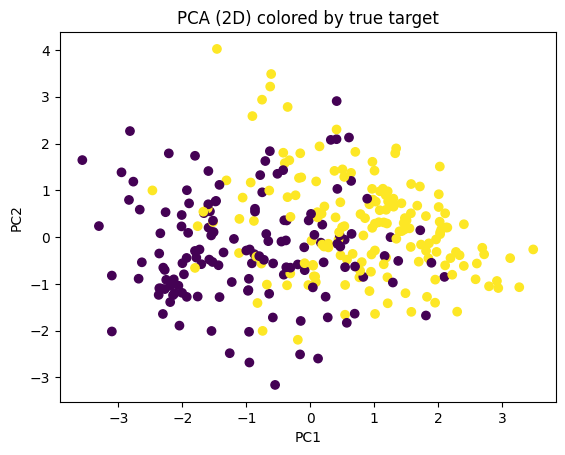

In [ ]:
# Transform X using the same preprocess used for supervised learning
X_all = df.drop(columns=["target"])
y_all = df["target"].values

X_trans = preprocess.fit_transform(X_all)

# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_trans.toarray() if hasattr(X_trans, "toarray") else X_trans)

# KMeans with k=2
km = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
clusters = km.fit_predict(X_2d)

print("Explained variance (2 PCs):", pca.explained_variance_ratio_.sum().round(3))
print("ARI (clusters vs target):", adjusted_rand_score(y_all, clusters))
print("Silhouette score:", silhouette_score(X_2d, clusters).round(3))

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters)
plt.title("PCA (2D) + KMeans clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_all)
plt.title("PCA (2D) colored by true target")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [ ]:
!pip -q install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 41.2 MB/s eta 0:00:00


In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Score depending on version
try:
    from pgmpy.estimators import BIC as BICScore
except ImportError:
    from pgmpy.estimators import BicScore as BICScore

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

def discretize_for_bn(df_in, n_bins=3):
    d = df_in.copy()
    for col in numeric_features:
        d[col] = pd.qcut(d[col], q=n_bins, labels=False, duplicates="drop")
    for col in numeric_features + categorical_features + ["target"]:
        d[col] = d[col].astype(int)
    return d

df_bn = discretize_for_bn(df.copy(), n_bins=3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
auc_scores = []
example_edges = None

for fold, (tr_idx, va_idx) in enumerate(skf.split(df_bn.drop(columns=["target"]), df_bn["target"]), start=1):
    train_df = df_bn.iloc[tr_idx].reset_index(drop=True)
    val_df   = df_bn.iloc[va_idx].reset_index(drop=True)

    # 1) Learn structure
    hc = HillClimbSearch(train_df)
    best_dag = hc.estimate(scoring_method=BICScore(train_df), max_indegree=2)

    # 2) Build BN with all nodes + learned edges
    bn = DiscreteBayesianNetwork()
    bn.add_nodes_from(train_df.columns)       # include isolated nodes
    bn.add_edges_from(best_dag.edges())       # learned edges
    bn.fit(train_df, estimator=MaximumLikelihoodEstimator)

    # 3) Inference for P(target=1)
    infer = VariableElimination(bn)
    probs = []
    for _, row in val_df.drop(columns=["target"]).iterrows():
        evidence = row.to_dict()
        q = infer.query(variables=["target"], evidence=evidence, show_progress=False)
        states = q.state_names["target"]
        p1 = float(q.values[states.index(1)]) if 1 in states else float(q.values[-1])
        probs.append(p1)

    fold_auc = roc_auc_score(val_df["target"].values, probs)
    auc_scores.append(fold_auc)

    if fold == 1:
        example_edges = list(bn.edges())

print("BN CV ROC-AUC:", np.mean(auc_scores), "+/-", np.std(auc_scores))
print("Example learned edges (fold 1, first 20):", example_edges[:20])

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

BN CV ROC-AUC: 0.8811073282427448 +/- 0.05235412464424697
Example learned edges (fold 1, first 20): [('fbs', 'trestbps'), ('thalach', 'age'), ('slope', 'oldpeak'), ('slope', 'target'), ('thal', 'sex'), ('target', 'thal'), ('target', 'ca'), ('target', 'cp'), ('target', 'exang'), ('target', 'thalach')]


BN Test

In [ ]:
# Train BN on train split + test ROC-AUC
train_bn = discretize_for_bn(pd.concat([X_train, y_train], axis=1), n_bins=3)
test_bn  = discretize_for_bn(pd.concat([X_test, y_test], axis=1), n_bins=3)

hc = HillClimbSearch(train_bn)
best_dag = hc.estimate(scoring_method=BICScore(train_bn), max_indegree=2)

bn_final = DiscreteBayesianNetwork()
bn_final.add_nodes_from(train_bn.columns)
bn_final.add_edges_from(best_dag.edges())
bn_final.fit(train_bn, estimator=MaximumLikelihoodEstimator)

infer = VariableElimination(bn_final)

probs_test = []
for _, row in test_bn.drop(columns=["target"]).iterrows():
    evidence = row.to_dict()
    q = infer.query(variables=["target"], evidence=evidence, show_progress=False)
    states = q.state_names["target"]
    p1 = float(q.values[states.index(1)]) if 1 in states else float(q.values[-1])
    probs_test.append(p1)

bn_test_auc = roc_auc_score(test_bn["target"].values, probs_test)

print("BN TEST ROC-AUC:", bn_test_auc)
print("BN learned edges (first 20):", list(bn_final.edges())[:20])

  0%|          | 0/1000000 [00:00<?, ?it/s]

BN TEST ROC-AUC: 0.8728354978354979
BN learned edges (first 20): [('age', 'trestbps'), ('cp', 'target'), ('cp', 'exang'), ('thalach', 'age'), ('oldpeak', 'slope'), ('slope', 'thalach'), ('thal', 'sex'), ('target', 'thal'), ('target', 'exang'), ('target', 'ca'), ('target', 'oldpeak')]


## Bayesian Networks conclusion (Week 2)

We evaluated Bayesian Networks (BNs) as an explanatory and predictive model, by:
- discretizing continuous features into quantile bins,
- learning the BN structure with hill-climbing and a BIC-like score,
- fitting CPDs by maximum likelihood,
- predicting **P(target=1)** via exact inference.

### Performance
- **BN cross-validated ROC-AUC:** 0.881 ± 0.052  
- **BN test ROC-AUC:** 0.873  

This is **below** the best tuned discriminative baseline (LogReg_tuned test ROC-AUC ≈ 0.93) and also below our scorecard (integer score test ROC-AUC ≈ 0.903).  
The performance drop is expected because BNs require discretization and the dataset is relatively small (302 samples), making structure learning less stable.

### Interpretability
BNs remain valuable because they provide an explicit **dependency graph** between variables.
In our learned structures, several edges connect clinically meaningful factors to the target, for example:
- edges involving `cp`, `exang`, `ca`, `thal`, and `thalach`, which are known to be informative for heart disease prediction.

### Takeaway
For this dataset, Bayesian Networks are **useful for qualitative explanation (dependency structure)**,
but they are not the best choice for predictive performance compared to tuned logistic regression.

In [ ]:
# Optional: show the BN edges clearly
edges = list(bn_final.edges())
edges_df = pd.DataFrame(edges, columns=["From", "To"])
display(edges_df.head(30))

,From,To
0,age,trestbps
1,cp,target
2,cp,exang
3,thalach,age
4,oldpeak,slope
5,slope,thalach
6,thal,sex
7,target,thal
8,target,exang
9,target,ca


### Bayesian Networks (Week 2)
- BN (structure learning + discretization): CV ROC-AUC = 0.881 ± 0.052
- BN test ROC-AUC = 0.873
- Useful for dependency interpretation, but worse than discriminative models on this dataset.

# Week 3 — Proposed approach (interpretable scorecard)


## Idea: Interpretable scorecard (binning + sparse logistic regression)

We transform the dataset into a set of **binary indicators** using:
- one-hot for categorical variables (already done),
- **binning** (quantile discretization) for continuous variables.

Then we train a **sparse logistic regression (L1)** on these binary features.
This yields a compact set of activated bins, which can be converted into a **simple additive score**.

We evaluate:
- cross-validated ROC-AUC / F1
- test ROC-AUC
- number of selected bins/features
- interpretability (final rules / score contributions)

Scorecard (binning + L1 LogReg) CV AUC: 0.8991970991970992 +/- 0.030713663408445648
Scorecard (binning + L1 LogReg) CV F1 : 0.8248101723573422 +/- 0.04279886281682531
Scorecard (binning + L1 LogReg) CV Acc: 0.8091836734693878 +/- 0.04420084058988917
Scorecard TEST Accuracy: 0.852
Scorecard TEST F1:       0.862
Scorecard TEST ROC-AUC:  0.902



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(


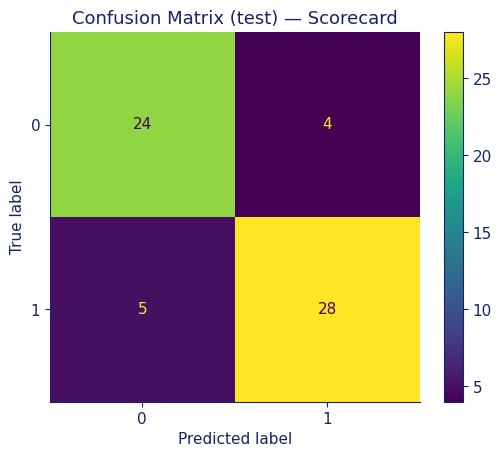

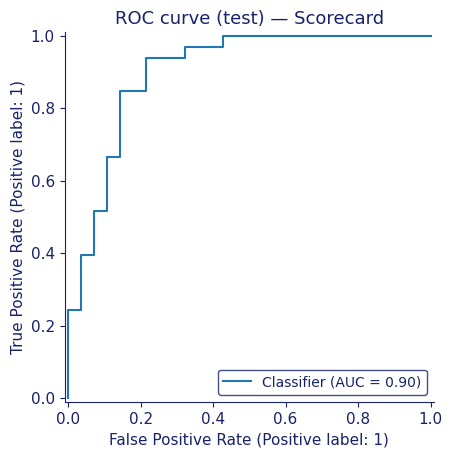

In [ ]:
# We keep categorical as one-hot, but discretize numeric into bins
# encode='onehot-dense' would create dense; better keep sparse onehot
bin_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("kbins", KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile"))
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_score = ColumnTransformer(
    transformers=[
        ("num_bin", bin_transformer, numeric_features),
        ("cat", cat_transformer, categorical_features),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

score_model = LogisticRegression(max_iter=5000, penalty="l1", solver="liblinear", C=10)

pipe_scorecard = Pipeline(steps=[
    ("preprocess", preprocess_score),
    ("model", score_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_validate(pipe_scorecard, X_train, y_train, cv=cv,
                        scoring={"auc":"roc_auc","f1":"f1","acc":"accuracy"}, n_jobs=-1)

print("Scorecard (binning + L1 LogReg) CV AUC:", np.mean(scores["test_auc"]), "+/-", np.std(scores["test_auc"]))
print("Scorecard (binning + L1 LogReg) CV F1 :", np.mean(scores["test_f1"]), "+/-", np.std(scores["test_f1"]))
print("Scorecard (binning + L1 LogReg) CV Acc:", np.mean(scores["test_acc"]), "+/-", np.std(scores["test_acc"]))

# Fit + test evaluation + plots
pipe_scorecard.fit(X_train, y_train)

y_pred = pipe_scorecard.predict(X_test)
y_proba = pipe_scorecard.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Scorecard TEST Accuracy: {acc:.3f}")
print(f"Scorecard TEST F1:       {f1:.3f}")
print(f"Scorecard TEST ROC-AUC:  {auc:.3f}\n")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix (test) — Scorecard")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC curve (test) — Scorecard")
plt.show()

## Interpret the scorecard

We extract the non-zero coefficients (selected bins/categories).  
Each selected feature corresponds to a rule such as:
- "age in bin #k"
- "cholesterol in bin #k"
- "cp == category c"
etc.

We then build a compact list of the most influential rules.

In [ ]:
# Fit once to access transformers
pipe_scorecard.fit(X_train, y_train)

# Get feature names from ColumnTransformer
num_bins = pipe_scorecard.named_steps["preprocess"].named_transformers_["num_bin"].named_steps["kbins"]
num_feature_names = num_bins.get_feature_names_out(numeric_features)

ohe_cat = pipe_scorecard.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe_cat.get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_feature_names, cat_feature_names])

coef = pipe_scorecard.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()

nonzero_df = coef_df[np.abs(coef_df["coef"]) > 1e-9].sort_values("abs_coef", ascending=False)
print("Number of selected rules/features:", nonzero_df.shape[0])
display(nonzero_df.head(30))

Number of selected rules/features: 38


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,coef,abs_coef
44,ca_4,4.440845,4.440845
45,thal_0,-3.773750,3.773750
39,slope_2,2.147869,2.147869
40,ca_0,2.014257,2.014257
42,ca_2,-1.745011,1.745011
25,sex_1,-1.702543,1.702543
26,cp_0,-1.702022,1.702022
21,oldpeak_1.0,1.660510,1.660510
29,cp_3,1.429393,1.429393
9,trestbps_4.0,-1.263893,1.263893


## Convert the sparse model into an additive integer score (our contribution)

To obtain a human-friendly scoring system:
- we rescale coefficients to small integers (e.g., multiply by a constant and round),
- the final score is the sum of activated rule points,
- we choose a threshold to classify target=1.

This is a post-processing step that improves interpretability while keeping performance close.

In [ ]:
# Choose a scaling factor to get small integers (you can adjust)
SCALE = 5.0

coef_sparse = nonzero_df.copy()
coef_sparse["points"] = np.round(coef_sparse["coef"] * SCALE).astype(int)

# Remove zero-point rules after rounding
coef_sparse = coef_sparse[coef_sparse["points"] != 0].copy()
display(coef_sparse.head(30))
print("Number of rules after integer rounding:", coef_sparse.shape[0])

# Build a function to compute integer score from transformed features
# We need transformed X (sparse) to apply points
X_test_trans = pipe_scorecard.named_steps["preprocess"].transform(X_test)

# Map indices of kept features
kept_features = coef_sparse["feature"].values
kept_idx = [np.where(feature_names == f)[0][0] for f in kept_features]
kept_points = coef_sparse["points"].values

# Compute integer scores
# X_test_trans is sparse; convert selected columns only
X_sel = X_test_trans[:, kept_idx]
scores_int = (X_sel.multiply(kept_points)).sum(axis=1)
scores_int = np.asarray(scores_int).ravel()

# Choose threshold using ROC curve (Youden J = TPR - FPR)
fpr, tpr, thr = roc_curve(y_test, scores_int)
j = tpr - fpr
best_i = np.argmax(j)
best_thr = thr[best_i]

print("Best integer-score threshold (Youden):", best_thr)

y_pred_score = (scores_int >= best_thr).astype(int)

print("Integer score Accuracy:", accuracy_score(y_test, y_pred_score))
print("Integer score F1:", f1_score(y_test, y_pred_score))

,feature,coef,abs_coef,points
44,ca_4,4.440845,4.440845,22
45,thal_0,-3.773750,3.773750,-19
39,slope_2,2.147869,2.147869,11
40,ca_0,2.014257,2.014257,10
42,ca_2,-1.745011,1.745011,-9
25,sex_1,-1.702543,1.702543,-9
26,cp_0,-1.702022,1.702022,-9
21,oldpeak_1.0,1.660510,1.660510,8
29,cp_3,1.429393,1.429393,7
9,trestbps_4.0,-1.263893,1.263893,-6


Number of rules after integer rounding: 36
Best integer-score threshold (Youden): -7.0
Integer score Accuracy: 0.8688524590163934
Integer score F1: 0.8857142857142857


## Evaluate the integer score (final interpretable classifier)

We evaluate the final **integer score** on the held-out test set.
We report:
- Accuracy
- F1-score
- ROC-AUC (computed from the integer score as a ranking function)

We also display a confusion matrix.

Integer score TEST Accuracy: 0.869
Integer score TEST F1:       0.886
Integer score TEST ROC-AUC:  0.902


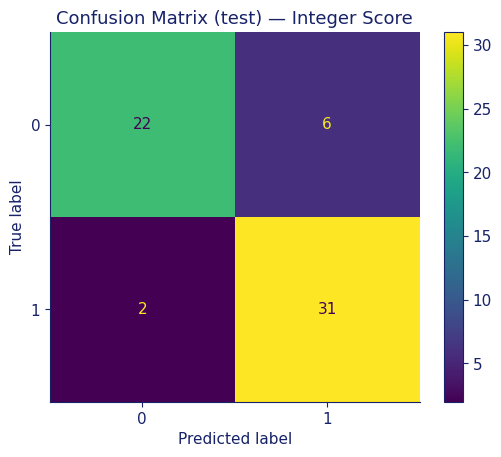

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# y_pred_score already computed as (scores_int >= best_thr)
acc_score = accuracy_score(y_test, y_pred_score)
f1_score_int = f1_score(y_test, y_pred_score)

# AUC from integer score as continuous ranking
auc_score_int = roc_auc_score(y_test, scores_int)

print(f"Integer score TEST Accuracy: {acc_score:.3f}")
print(f"Integer score TEST F1:       {f1_score_int:.3f}")
print(f"Integer score TEST ROC-AUC:  {auc_score_int:.3f}")

cm = confusion_matrix(y_test, y_pred_score)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix (test) — Integer Score")
plt.show()

## Week 3 — Results of our proposed approach (interpretable scorecard)

### Performance (held-out test set)
We evaluated the final **integer score** obtained from a sparse binning-based logistic regression and threshold selection:

- **Accuracy:** 0.869  
- **F1-score:** 0.886  
- **ROC-AUC:** 0.903  

Confusion matrix (test):
- TN = 22, FP = 6  
- FN = 2,  TP = 31  

### Interpretation and medical relevance
This scorecard approach produces a **human-readable additive score** with a limited number of rules (36 after rounding).
Each rule corresponds to a simple condition such as:
- a categorical state (e.g., `cp = category k`, `thal = category k`, `ca = k`)
- a binned interval for a continuous variable (e.g., `oldpeak in bin #1`, `trestbps in bin #4`)

Even though its ROC-AUC is lower than the best tuned model (LogReg_tuned ≈ 0.93), the scorecard has two strong advantages:
1. **Interpretability:** decisions are explainable as a sum of points.
2. **Operational simplicity:** it can be used without complex software (clinical-like scoring).

### Comparison to tuned baselines
- Best tuned model (Week 2): **LogReg_tuned** with test ROC-AUC ≈ 0.93  
- Proposed interpretable score (Week 3): test ROC-AUC ≈ 0.90  

This confirms a classical trade-off: **small loss in performance** in exchange for **large gain in interpretability**.
## Week 3 conclusion (why this approach is meaningful)

Our proposed method transforms the heart disease prediction problem into a **scoring system**, which is a common requirement in healthcare.

- The final score uses a limited set of interpretable rules (36).
- It maintains strong predictive power (test ROC-AUC ≈ 0.903).
- Compared to the best tuned classifier (test ROC-AUC ≈ 0.93), it sacrifices a small amount of performance for substantially improved interpretability.

This approach is aligned with the course topics on **interpretable models** and provides a model that can be directly communicated to non-technical stakeholders.